In [1]:
import pandas as pd ## Обновить pandas до последней версии
import numpy as np
import math
import os
import glob
import mysql.connector
import datetime
from mysql.connector import errorcode
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
from datetime import date
import string
from IPython.display import display, HTML

from os import listdir
from os.path import isfile, join

import matplotlib as matplotlib
from decimal import Decimal
import math
import statistics

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [2]:
my_path = input("Введите путь папки, в которой будут лежать все ваши файлы (пример формата C:\\Users\\User\\Documents\\Python Scripts\\IT\\Untitled Folder): ")
while my_path  == '':
    print("Ошибка: вы не ввели путь папки")
    my_path = input("Введите путь папки, в которой будут лежать все ваши файлы (пример формата C:\\Users\\User\\Documents\\Python Scripts\\IT\\Untitled Folder): ")
print("Вы ввели '" + str(my_path)+"'")

print("Введите данные для использования MySQL")
user = input("Введите имя пользователя (user name): ")
while user  == '':
    print("Ошибка: вы не ввели имя пользователя")
    user = input("Введите имя пользователя (user name): ")
print("Вы ввели '" + str(user)+"'")
database = input("Введите название базы данных (database name): ")
while database  == '':
    print("Ошибка: вы не ввели название базы данных")
    database = input("Введите название базы данных (database name): ")
print("Вы ввели '" + str(database)+"'")

Введите путь папки, в которой будут лежать все ваши файлы (пример формата C:\Users\User\Documents\Python Scripts\IT\Untitled Folder): C:\Users\plaps\Desktop\IT\project\Untitled Folder
Вы ввели 'C:\Users\plaps\Desktop\IT\project\Untitled Folder'
Введите данные для использования MySQL
Введите имя пользователя (user name): project_user
Вы ввели 'project_user'
Введите название базы данных (database name): project_db
Вы ввели 'project_db'


#### Блок Ивахненко Анастасии и Соколовой Анастасии

#### Задаём горизонт риска в месяцах

In [3]:
risk_horizon = input("Выберите горизонт риска в месяцах: ")
while str(risk_horizon)  == '':
    print("Ошибка: вы не выбрали горизонт риска")
    risk_horizon = input("Выберите горизонт риска в месяцах: ")
print("Вы ввели горизонт риска " + str(risk_horizon)+" мес.")

Выберите горизонт риска в месяцах: 23
Вы ввели горизонт риска 23 мес.


In [4]:
risk_horizon = int(risk_horizon)

In [5]:
cnx = mysql.connector.connect(host = 'localhost', database = database, user = user)
cursor = cnx.cursor(buffered=True)

payments_table = pd.read_sql_query("""SELECT contracts.contract_number, term_month, payment_date, amount_due,amount_paid
FROM contracts 
INNER JOIN payments on contracts.contract_number = payments.contract_number""", cnx)
payments_table.keys()

Index(['contract_number', 'term_month', 'payment_date', 'amount_due',
       'amount_paid'],
      dtype='object')

In [6]:
default_info_with_risk_horizon = [] #лист дефолтов на горизонте риска - переменная, куда буду добавляться данные типа
                                    #(номер контракта, дата дефолта, флаг дефолт/недефолт)

In [7]:
for i in payments_table['contract_number'].unique():
    table = payments_table[payments_table['contract_number'] == i]
    if table.iloc[0][1] >= risk_horizon:
        table = table[:risk_horizon]
        table = table.reset_index()
        for j in range(0, table.shape[0]-3):
            if (table['amount_paid'][j] < table['amount_due'][j] and table['amount_paid'][j+1] < table['amount_due'][j+1] and
                table['amount_paid'][j+2] < table['amount_due'][j+2] and table['amount_paid'][j+3] < table['amount_due'][j+3]):
                #проверяем, что заемщик не платит 4 даты подряд
                default_date = table['payment_date'][j + 3] #фиксируем дату просрочки
                default_date = (str(pd.to_datetime(default_date).year) + '-' + str(pd.to_datetime(default_date).month) + 
                                '-' + str(pd.to_datetime(default_date).day)) #корректируем формат даты просрочки
                while (i, '0000-00-00', 0) in default_info_with_risk_horizon:
                                default_info_with_risk_horizon.remove ((i, '0000-00-00', 0)) 
                        #исключаем из нашего листа дефолтов нулевые даты для дефолтеров
                default_info_with_risk_horizon.append((i, default_date, 1)) 
                break 
            else: default_info_with_risk_horizon.append((i, '0000-00-00', 0))
    
default_info_with_risk_horizon[:5]

[(100022, '0000-00-00', 0),
 (100022, '0000-00-00', 0),
 (100022, '0000-00-00', 0),
 (100022, '0000-00-00', 0),
 (100022, '0000-00-00', 0)]

In [8]:
data_with_risk_horizon = list(set(default_info_with_risk_horizon))
print (len(data_with_risk_horizon))
data_with_risk_horizon

36


[(100518, '0000-00-00', 0),
 (100320, '0000-00-00', 0),
 (100122, '0000-00-00', 0),
 (100797, '0000-00-00', 0),
 (101028, '0000-00-00', 0),
 (100206, '0000-00-00', 0),
 (100933, '0000-00-00', 0),
 (100176, '0000-00-00', 0),
 (100856, '0000-00-00', 0),
 (100190, '0000-00-00', 0),
 (100455, '0000-00-00', 0),
 (100872, '0000-00-00', 0),
 (100524, '0000-00-00', 0),
 (100052, '2017-12-30', 1),
 (100990, '0000-00-00', 0),
 (100127, '0000-00-00', 0),
 (100441, '0000-00-00', 0),
 (100068, '0000-00-00', 0),
 (100668, '2018-6-29', 1),
 (100520, '0000-00-00', 0),
 (100869, '0000-00-00', 0),
 (100997, '0000-00-00', 0),
 (100303, '0000-00-00', 0),
 (100431, '0000-00-00', 0),
 (100297, '0000-00-00', 0),
 (100368, '0000-00-00', 0),
 (100684, '2017-12-14', 1),
 (100476, '0000-00-00', 0),
 (100765, '0000-00-00', 0),
 (100552, '0000-00-00', 0),
 (100847, '0000-00-00', 0),
 (100022, '0000-00-00', 0),
 (100689, '0000-00-00', 0),
 (100600, '0000-00-00', 0),
 (100380, '0000-00-00', 0),
 (100703, '0000-00-00

#### Промежуточная таблица

In [9]:
cnx = mysql.connector.connect(host = 'localhost', database = database, user = user)
cursor = cnx.cursor(buffered=True)

cursor.execute("""CREATE TABLE IF NOT EXISTS contracts_risk_horizon_{0}_months 
(contract_number INT, 
bankruptcy BOOLEAN, 
date_of_default DATE)""".format(risk_horizon))

cnx.commit()

In [10]:
for i in data_with_risk_horizon:
    cursor.execute("""INSERT INTO contracts_risk_horizon_{0}_months 
    VALUES
    (%d, %d, '%s')""".format(risk_horizon) % (
    i[0],
    i[2],
    i[1]))
    
cnx.commit()

#### Промежуточная таблица

In [10]:
cursor.execute("""CREATE TABLE IF NOT EXISTS borrowers_default_with_risk_horizon_{0}_months AS (SELECT A.id, bankruptcy, date_of_default
FROM
(SELECT bankruptcy, id, date_of_default
FROM contracts
INNER JOIN contracts_risk_horizon_{1}_months ON
contracts.contract_number = contracts_risk_horizon_{2}_months.contract_number) AS A
INNER JOIN applications ON
applications.id = A.id)""".format(risk_horizon, risk_horizon, risk_horizon))

cnx.commit()

In [11]:
applications_with_risk_horizon = pd.read_sql_query("""SELECT age, car_owner, children, education, employed_by, family, 
gender, house_ownership, housing, income, income_type, marital_status, position, bankruptcy FROM
(SELECT bankruptcy, id
FROM contracts
INNER JOIN contracts_risk_horizon_{0}_months ON
contracts.contract_number = contracts_risk_horizon_{1}_months.contract_number) AS A
INNER JOIN applications ON
applications.id = A.id""".format(risk_horizon, risk_horizon), cnx)

In [12]:
applications_with_risk_horizon

,age,car_owner,children,education,employed_by,family,gender,house_ownership,housing,income,income_type,marital_status,position,bankruptcy
0,50,0,0,2,6,1,0,1,0,112500,3,4,5.0,0
1,40,1,1,2,23,2,1,1,0,360000,3,2,5.0,0
2,37,0,0,0,14,2,0,1,0,54000,2,1,3.0,0
3,40,1,1,0,1,3,0,1,0,171000,0,1,0.0,0
4,43,1,1,2,17,3,1,0,0,225000,3,1,4.0,0
5,58,0,0,2,5,2,0,0,0,130500,2,1,6.0,0
6,51,1,0,2,25,2,1,0,0,81000,1,1,NaN,0
7,56,0,0,2,1,2,0,1,0,90000,3,1,1.0,0
8,33,0,1,0,9,2,0,1,0,90000,2,3,3.0,0
9,40,1,1,2,20,3,0,1,0,202500,0,1,9.0,0


In [16]:
applications_with_risk_horizon = applications_with_risk_horizon.rename(index=str, columns={"bankruptcy": "default"})

In [17]:
applications_with_risk_horizon ## Выгрузить её в csv

,age,age_of_car,children,education,employed_by,family,gender,house_ownership,housing,income,income_type,marital_status,position,default
0,40,14.0,1,2,20,3,0,1,0,202500,0,1,10,0
1,58,NaN,0,2,23,2,1,1,0,121500,3,1,5,0
2,50,NaN,0,2,7,2,0,1,0,202500,3,1,6,0
3,46,NaN,0,2,1,2,0,1,0,292500,0,0,0,0
4,43,23.0,1,2,17,3,1,0,0,225000,3,1,5,0
5,55,NaN,0,2,13,1,1,1,0,121500,3,3,4,0
6,67,10.0,0,0,25,2,1,1,0,324000,1,0,0,0
7,37,NaN,0,0,14,2,0,1,0,54000,2,1,4,0
8,33,NaN,1,0,9,2,0,1,0,90000,2,3,4,0
9,46,3.0,0,0,1,2,1,1,0,180000,3,1,7,0


#### Блок Лапшовой Полины

In [18]:
cursor.execute("""SELECT DISTINCT column_name FROM applications_dict""")
char_vars =  cursor.fetchall()
list_char_vars = []
for i in range(0, len(char_vars)):
    list_char_vars.append(char_vars[i][0])
additionally_append = ['family','children']  # что ещё считаем нужным рассматривать как категориальную
for i in range (0, len(additionally_append)):
    list_char_vars.append(additionally_append[i])

Для вычисления метрик WOE, IV, за основу взят код из ресурса https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb с некоторыми преобразованиями. По всем категориальным переменным применяется стандартная процедура вычисления WOE и IV, для непрерывных первоначально производится разбиение на категории. Данный код  категоризует по квантилям.

In [19]:
# define a binning function
def mono_bin(Y, X, max_bin, force_bin):
    n = max_bin
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True, sort = True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    np.seterr(divide='ignore')
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    np.seterr(divide='ignore')
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3["CATEGORY_NAME"] = "NO_CATEGORY"

    d3 = d3[['VAR_NAME', 'CATEGORY_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 
             'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True, sort = True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    np.seterr(divide='ignore')
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    np.seterr(divide='ignore')
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3["CATEGORY_NAME"] = "NO_CATEGORY"
    d3 = d3[['VAR_NAME','CATEGORY_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, default, max_bin, force_bin):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2 and i not in list_char_vars:
                conv = mono_bin(default, df1[i], max_bin, force_bin)
                conv["VAR_NAME"] = i
                for j in range(0, len(conv)):
                    conv.iloc[j, conv.columns.get_loc('CATEGORY_NAME')] = str(conv['MIN_VALUE'][j])+' - '+str(conv['MAX_VALUE'][j])
                
                count = count + 1
            else:
                conv = char_bin(default, df1[i])
                conv["VAR_NAME"] = i
                if i not in additionally_append:
                    cursor.execute("""SELECT category, encoding FROM applications_dict WHERE column_name = '{0}' """.format(i))
                    keys = cursor.fetchall()

                    for j in range(0, len(keys)):
                        conv.loc[conv['MIN_VALUE'] == keys[j][1], 'CATEGORY_NAME'] =  keys[j][0]
                else:
                    for j in range(0, len(conv)):
                        conv.iloc[j, conv.columns.get_loc('CATEGORY_NAME')] = str(conv['MIN_VALUE'][j])
                
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [20]:
def ROC1 (var_name, max_tresholds):
        less_then_treshold  = 0
        more_then_treshold  = 1
        TPR = []
        FPR = []
        defaults_true = list(applications_with_risk_horizon.default)
        defaults_classified = pd.DataFrame(applications_with_risk_horizon[var_name])
        tresholds = np.arange(applications_with_risk_horizon[[var_name]].min()[0],applications_with_risk_horizon[[var_name]].max()[0]+2,
                              (applications_with_risk_horizon[[var_name]].max()[0]-
                               applications_with_risk_horizon[[var_name]].min()[0])/(max_tresholds-1))
       
        for i in tresholds:

            TP = 0
            TN = 0
            FP = 0
            FN = 0
            
            defaults_classified.loc[defaults_classified[var_name] < i, 'defaults_classified'] = less_then_treshold
            defaults_classified.loc[defaults_classified[var_name] >= i, 'defaults_classified'] = more_then_treshold
            
            for j in range(0, len(defaults_classified)):
                if defaults_classified['defaults_classified'][j] == 1 and defaults_true[j] == 1:
                    TP += 1
                if defaults_classified['defaults_classified'][j] == 0 and defaults_true[j] == 0:
                    TN += 1
                if defaults_classified['defaults_classified'][j] == 1 and defaults_true[j] == 0:
                    FP += 1  
                if defaults_classified['defaults_classified'][j] == 0 and defaults_true[j] == 1:
                    FN += 1

            TPR_tr = TP/(TP+FN)
            FPR_tr = FP/(FP+TN)
            
            TPR.append(TPR_tr)
            FPR.append(FPR_tr)
            
        ROC_AUC = metrics.auc(FPR,TPR)
        GINI = 2*ROC_AUC-1    
        return TPR, FPR, GINI

In [46]:
def plot_metric(var_name, graph_type):
    if var_name in list_char_vars and graph_type == 'ROC':
        print()
        print('Для категориальной переменной не строится ROC-кривая, будет построен график WOE')
        graph_type = 'WOE'
    if graph_type == 'WOE':
        small_df = final_iv[final_iv['VAR_NAME'] == var_name]
        display(small_df)
        fig = plt.figure(1, [10, 5])
        plt.bar(small_df['CATEGORY_NAME'], small_df['WOE'])
        plt.title('WOE for '+ var_name)
        plt.grid(True)
        plt.xlabel('Category', fontdict=None, labelpad=15)
        plt.ylabel('WOE', fontdict=None, labelpad=15)
        if small_df.shape[0] <= 4:
            rotation_type = 'horizontal'
        else:
            rotation_type = 'vertical'
        plt.xticks(rotation=rotation_type)
        my_file = Path(my_path+'\\output_2\\WOE_{0}.png'.format(var_name))
        if my_file.is_file() == False:
                    plt.savefig(my_path + '\\output_2\\WOE_{0}.png'.format(var_name))
        plt.show()

    if graph_type == 'ROC' and var_name not in list_char_vars:
        TPR, FPR, GINI = ROC1(var_name, max_tresholds)
       # TPR, FPR, GINI = ROC2(var_name, treshold)
        fig = plt.figure(1, [10, 5])        
        plt.xlabel('False Positive Rate', fontdict=None, labelpad=15)
        plt.ylabel('True Positive Rate', fontdict=None, labelpad=15)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title('ROC for '+var_name)
        plt.plot(FPR, TPR, color='blue', lw=2, label='GINI=%0.2f'% GINI)
        plt.legend(loc="lower right")
        my_file = Path(my_path+'\\output_2\\ROC_{0}.png'.format(var_name))
        if my_file.is_file() == False:
                    plt.savefig(my_path + '\\output_2\\ROC_{0}.png'.format(var_name))
        plt.show()

#### В ячейку ниже впишите по образцу:
* в переменную **_var__name_** желаемую переменную из таблицы applications. Список предлагаемых переменных предложен под ячейкой для ввода
* в переменную **_graph__type_** тип метрики, которую вы хотите построить. Вписать можно либо значение **_'ROC'_** для непрерывных переменных, либо значение **_'WOE'_** для категориальных переменных, либо для категоризируемых по квантилям в ходе выполнения кода непрерывных переменных.<br><br>
Если вы выбрали построение **_'ROC'_**:<br><br>
* в переменную **_max__tresholds_** максимальное количество порогов отсечения, используемых при построении ROC (влияет как на качество построения, так и на скорость исполнения, можете оставить дефолтное значение 1000)<br><br>
Если вы выбрали построение **_'WOE'_** по непрерывной переменной:<br><br>
* в переменную **_max__bin_** максимальное число категорий, которое вы хотите получить
* в переменную **_force__bin_** минимальное число категорий, которое вы хотите получить<br><br>
По умолчанию ниже приведен пример для категориальной переменной, а после этого в самом конце - для непрерывной 

In [13]:
to_choose = [
 'age',
 'car_owner',
 'children',
 'education',
 'employed_by',
 'family',
 'gender',
 'house_ownership',
 'housing',
 'income',
 'income_type',
 'marital_status',
 'position']

In [14]:
print("Переменные для построения метрик WOE или ROC можно брать из этого списка:")
print(to_choose)

Переменные для построения метрик WOE или ROC можно брать из этого списка:
['age', 'car_owner', 'children', 'education', 'employed_by', 'family', 'gender', 'house_ownership', 'housing', 'income', 'income_type', 'marital_status', 'position']


In [5]:
var_name = input("Выберите название переменной для построения метрики: ")
while str(var_name)  == '' or str(var_name) not in list(applications_with_risk_horizon):
    if var_name not in list(applications_with_risk_horizon) and var_name != '':
        print("Ошибка: выбор такой переменной не предусмотрен или переменная не существует")
    if var_name == '':
        print("Ошибка: вы не выбрали название переменной для построения метрики")
    var_name = input("Выберите название переменной для построения метрики: ")
print("Вы ввели переменную '" +var_name+"'")

graph_type = input("Выберите метрику для построения (WOE или ROC): ")
while str(graph_type)  == '' or str(graph_type) not in ['WOE', 'ROC'] or (var_name in list_char_vars and graph_type == 'ROC'):
    if graph_type != 'WOE' and graph_type != 'ROC' and graph_type !='':
        print("Ошибка: выбор такой метрики не предусмотрен или метрика не существует")
    if str(graph_type) == '':
        print("Ошибка: вы не выбрали тип метрики")
    if str(graph_type) == 'ROC' and var_name in list_char_vars:
        print("Для категориальной переменной не строится ROC-кривая, выберите опцию WOE")
    graph_type = input("Выберите метрику для построения (WOE или ROC): ")
print("Вы выбрали построение '" +graph_type+"'")


Выберите название переменной для построения метрики: education
Вы ввели переменную 'education'
Выберите метрику для построения (WOE или ROC): ROC
Для категориальной переменной не строится ROC-кривая, будет построен график WOE
Выберите метрику для построения (WOE или ROC): ROC
Для категориальной переменной не строится ROC-кривая, будет построен график WOE
Выберите метрику для построения (WOE или ROC): WOE
Вы выбрали построение 'WOE'


In [9]:
max_bin = 8
force_bin = 4
if graph_type == 'WOE' and var_name not in list_char_vars:
    
    max_bin = input("Выберите максимальное число категорий для категоризации непрерывных переменных: ")
    while str(max_bin)  == '':
        print("Ошибка: вы не выбрали максимальное число категорий для категоризации непрерывных переменных")
        max_bin = input("Выберите максимальное число категорий для категоризации непрерывных переменных: ")
    print("Вы ввели максимальное число категорий " + str(max_bin))

    force_bin = input("Выберите минимальное число категорий для категоризации непрерывных переменных: ")
    while str(force_bin)  == '':
        print("Ошибка: вы не выбрали минимальное число категорий для категоризации непрерывных переменных")
        force_bin = input("Выберите минимальное число категорий для категоризации непрерывных переменных: ")
    print("Вы ввели минимальное число категорий " + str(force_bin))

if graph_type == 'ROC':
    max_tresholds = input("""Выберите максимальное число порогов для построения ROC-кривой (при больших значениях 
                        может занять много времени, по умолчанию равен 1000): """)
    if max_tresholds == '':
        print("Будет задано дефолтное значение 1000 для порогов ROC-кривой")
    else:
        print("Вы ввели максимальное число категорий " + str(max_tresholds))


In [55]:
#var_name = 'age'
#graph_type = 'WOE'
if graph_type == 'WOE':
    max_bin = int(max_bin) # если WOE и разбиваем на бакеты
    force_bin = int(force_bin) # если WOE и разбиваем на бакеты
if graph_type == 'ROC':
    if max_tresholds  == '':
        max_tresholds = 1000
    else:
        max_tresholds = int(max_tresholds)

In [56]:
if graph_type == 'WOE':
    default = applications_with_risk_horizon.default
    force_bin = force_bin+1
    final_iv, IV = data_vars(applications_with_risk_horizon.drop('default', axis=1), default, max_bin, force_bin)

Выполним построение для выбранной переменной (к графику WOE прилагается таблица):

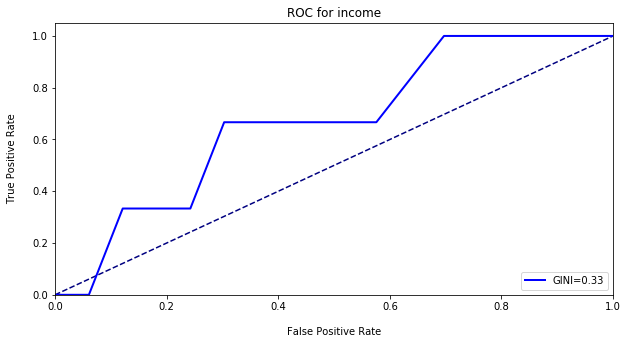

In [57]:
plot_metric(var_name, graph_type)

In [58]:
if graph_type == 'WOE':
    IV_sort = IV.sort_values('IV')
    iv_scores = np.array(IV_sort['IV'])
    data_normalizer = matplotlib.colors.Normalize()
    color_map = matplotlib.colors.LinearSegmentedColormap("my_map",{"red": [(0, 1.0, 1.0),(1.0, .5, .5)],
                                                                    "green": [(0, 0.5, 0.5),(1.0, 0, 0)],
                                                                    "blue": [(0, 0.50, 0.5),(1.0, 0, 0)]})

    N = len(IV_sort['IV'])
    x_nums = np.arange(1, N+1)

    fig = plt.figure(1, [14, 8]) 
    plt.barh(x_nums, IV_sort['IV'], align="center", color=color_map(data_normalizer(iv_scores)))
    plt.yticks(x_nums, IV_sort['VAR_NAME'],  fontweight='bold')
    for i, v in enumerate(iv_scores):
        #v = round(Decimal(v),2)
        plt.text(v+0.01, i+0.9, str(round(Decimal(v),2)), color='black',  fontweight='bold')
    plt.title('IV значения для всех переменных', fontweight='bold')
    my_file = Path(my_path+'\\output_2\\IV.png')
    if my_file.is_file() == False:
        plt.savefig(my_path + '\\output_2\\IV.png', dpi=300, bbox_inches='tight')
    plt.show()

#### Пример ROC для непрерывного income

In [125]:
#var_name = 'income'
#graph_type = 'ROC'
#max_bin = 10 # если WOE и разбиваем на бакеты
#force_bin = 5 # если WOE и разбиваем на бакеты
#max_tresholds = 1000

In [126]:
#if graph_type == 'WOE':
 #   default = applications_with_risk_horizon.default
  #  force_bin = force_bin+1
   # final_iv, IV = data_vars(applications_with_risk_horizon.drop('default', axis=1), default, max_bin, force_bin)

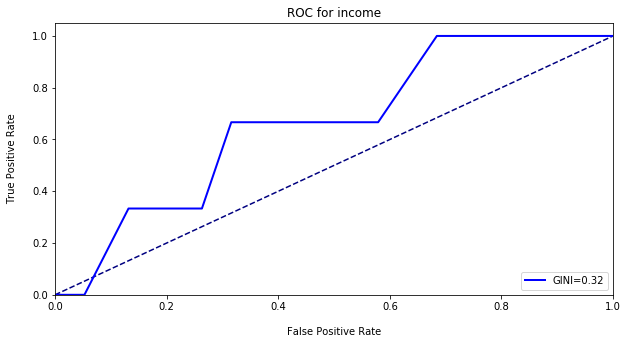

<Figure size 432x288 with 0 Axes>

In [127]:
#plot_metric(var_name, graph_type)
#plt.savefig(my_path + '\\output_2\\IV.png', dpi=300, bbox_inches='tight')

### Выгрузка данных (добавить выгрузку картинок и графиков)

In [49]:
my_file = Path(my_path+'\\output_2\\applications_with_risk_horizon_{0}_months.csv'.format(risk_horizon))
if my_file.is_file() == False:
    applications_with_risk_horizon.to_csv(my_path + '\\output_2\\applications_with_risk_horizon_{0}_months.csv'.format(risk_horizon),
                                      header=True)


In [59]:
cnx.close()

In [7]:
print("""part_2 выполнена, посмотрите на результаты в папке output_2""")

part_2 выполнена, посмотрите на результаты в папке output_2
